TRADE HISTORY LENGTH 2, CORRECTLY ORDERED 

YIELD CURVE HISTORY 5MIN_12_AVERAGE , CORRECTLY ORDERED 

In [270]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import gc

import numpy as np
from google.cloud import bigquery
from google.cloud import storage

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle


from ficc.utils.nelson_siegel_model import *
from ficc.utils.diff_in_days import *
from ficc.utils.auxiliary_functions import sqltodf


from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT, NUM_OF_DAYS_IN_YEAR
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

import sys
sys.path.append('../../')
from ficc_keras_utils import *
import ficc_keras_utils

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(f'TF Version: {tf.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TF Version: 2.7.0


In [233]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

bq_client = bigquery.Client()
storage_client = storage.Client()

##COMMON VARIABLES
#DATA WINDOW
train_start = ficc_keras_utils.train_start
train_end = ficc_keras_utils.train_end
test_start = ficc_keras_utils.test_start
test_end = ficc_keras_utils.test_end
#MODEL PARAMETERS 
VALIDATION_SPLIT = ficc_keras_utils.VALIDATION_SPLIT
LEARNING_RATE = ficc_keras_utils.LEARNING_RATE
BATCH_SIZE = ficc_keras_utils.BATCH_SIZE
NUM_EPOCHS = 150 #ficc_keras_utils.NUM_EPOCHS
DROPOUT = ficc_keras_utils.DROPOUT

##NOTEBOOK SPECIFIC VARIABLES 
TRADE_SEQUENCE_LENGTH = 2
YIELD_SEQUENCE_LENGTH = 11
NUM_FEATURES = 6
# target_variable = 'new_ys_diff'
target_variable = 'new_ys'

In [ ]:
print(train_start ,
train_end ,
test_start ,
test_end)

In [4]:
processed_data = pd.read_pickle('../../processed_data-2023-05-12.pkl')

In [ ]:
additional_features = ['ttypes', 'diff_size', 'abs_last_yield_spread', 'abs_diff_size', 'days_duration']
YS_COLS = ['max_ys_ys', 'max_ys_ttypes', 'max_ys_ago', 'max_ys_qdiff', 'min_ys_ys', 'min_ys_ttypes', 'min_ys_ago', 'min_ys_qdiff', 'max_qty_ys', 'max_qty_ttypes', \
           'max_qty_ago', 'max_qty_qdiff', 'min_ago_ys', 'min_ago_ttypes', 'min_ago_ago', 'min_ago_qdiff', 'D_min_ago_ys', 'D_min_ago_ttypes', 'D_min_ago_ago', 'D_min_ago_qdiff',\
           'P_min_ago_ys', 'P_min_ago_ttypes', 'P_min_ago_ago', 'P_min_ago_qdiff', 'S_min_ago_ys', 'S_min_ago_ttypes', 'S_min_ago_ago', 'S_min_ago_qdiff']
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)
    
for col in YS_COLS:
    if 'ttypes' in col and col not in PREDICTORS:
        PREDICTORS.append(col)
        CATEGORICAL_FEATURES.append(col)
    elif col not in PREDICTORS:
        NON_CAT_FEATURES.append(col)
        PREDICTORS.append(col)
        
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')
    
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')
    
for col in ['new_ficc_ycl', 'new_real_time_ficc_ycl']:     
    if col not in PREDICTORS:
        PREDICTORS.append(col)
        NON_CAT_FEATURES.append(col)

In [7]:
%%time

processed_data['yield_curve_history_5min_12_averaged_first_differenced'] = processed_data['yield_curve_history_5min_12_averaged']\
.apply(lambda x: -np.diff(x))\
.apply(lambda x: x[::-1])

CPU times: user 29 s, sys: 486 ms, total: 29.5 s
Wall time: 29.5 s


In [8]:
%%time

processed_data['trade_history_shortened'] = processed_data['trade_history'].apply(lambda x: x[:TRADE_SEQUENCE_LENGTH])

CPU times: user 11 s, sys: 498 ms, total: 11.5 s
Wall time: 11.4 s


In [9]:
%%time

processed_data['trade_history_fixed'] = processed_data['trade_history_shortened'].apply(lambda x: x[::-1, :])

CPU times: user 10.8 s, sys: 329 ms, total: 11.1 s
Wall time: 11.1 s


Add Overnight Movements

In [203]:
from ficc.yield_curve.YieldCurve import *
from ficc.yield_curve.time_series_functions import *
from ficc.yield_curve.auxiliary_functions import *

In [204]:
rtyc = RealTimeYieldCurve(start_date='2022-12-25', end_date='2023-04-01')
rtyc.initialize_data()

Setting start date to 2022-12-25 00:00:00-05:00
Setting end date to 2023-04-01 00:00:00-04:00
Loading real time yield curve values from BigQuery
Real time yield curve values loaded, data spans 2022-12-26 09:30:00 to 2023-03-31 15:59:00
Estimating yield curves for maturity T = 0.1 to T = 30.0
Estimating and saving yield curves for maturity T = 0.1 to T = 30.0


In [251]:
rtyc_values = rtyc.yield_curves.copy()
overnight_moves = between_day_overnight_move(rtyc_values)
overnight_moves.index = pd.to_datetime(overnight_moves.index)
overnight_moves_dict = overnight_moves[[5, 10, 30]].loc[train_start:].T.to_dict()

In [252]:
train_filter = (processed_data.trade_date < train_end) & (processed_data.trade_date >= train_start)
test_filter = (processed_data.trade_date >= test_start) & (processed_data.trade_date <test_end)
                                                            
train_dataframe = processed_data[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

test_dataframe = processed_data[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

print('Training data start: {}, end: {}'.format(train_dataframe.trade_date.min(),train_dataframe.trade_date.max()))
print('Test data start: {}, end: {}'.format(test_dataframe.trade_date.min(),test_dataframe.trade_date.max()))

Training data start: 2023-01-03 00:00:00, end: 2023-02-28 00:00:00
Test data start: 2023-03-01 00:00:00, end: 2023-03-31 00:00:00


In [257]:
def return_overnight_cols(trade_dates):
    default = dict(zip(range(3), np.zeros(3)))
    return pd.DataFrame(trade_dates.apply(lambda x: overnight_moves_dict.get(x, default).values()).to_list())

In [258]:
%%time

overnight_cols_train = return_overnight_cols(train_dataframe.trade_date)

CPU times: user 7.53 s, sys: 0 ns, total: 7.53 s
Wall time: 7.52 s


In [259]:
%%time

overnight_cols_test = return_overnight_cols(test_dataframe.trade_date)

CPU times: user 5 s, sys: 0 ns, total: 5 s
Wall time: 5 s


In [261]:
overnight_col_names = ['ficc_ycl_overnight_'+str(x) for x in [5, 10, 30]]
train_dataframe[overnight_col_names] = overnight_cols_train
test_dataframe[overnight_col_names] = overnight_cols_test

In [226]:
for col in overnight_col_names:
    if col not in PREDICTORS:
        PREDICTORS.append(col) 
    if col not in NON_CAT_FEATURES:
        NON_CAT_FEATURES.append(col)

In [263]:
overnight_col_names_subset = ['ficc_ycl_overnight_' + str(x) for x in [1, 5, 10, 30]] 
for col in overnight_col_names:
    if col not in PREDICTORS:
        PREDICTORS.append(col) 
    if col not in NON_CAT_FEATURES:
        NON_CAT_FEATURES.append(col)
        
        
overnight_col_names_subset = ['ficc_ycl_overnight_' + str(x) for x in [1, 2, 15, 30]] 
for col in overnight_col_names:
    if col in PREDICTORS:
        PREDICTORS.remove(col) 
    if col in NON_CAT_FEATURES:
        NON_CAT_FEATURES.remove(col)

Prep data for input

In [264]:
def create_input_new(df, trade_history_col, yield_history_cols):
    global encoders
    datalist = []
    
    for col in yield_history_cols:
        datalist.append(np.stack(df[col].to_numpy()))
        
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

def generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history,
                      yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []

    ############## INPUT BLOCK ###################
    for i in range(num_yield_history):
        inputs.append(layers.Input(name=f"yield_history_input_{yield_history_cols[i]}", 
                                           shape=(yield_history_lengths[i], 1), 
                                           dtype = tf.float32))
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[num_yield_history+2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[num_yield_history]))
    features = lstm_layer_2(features)


    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)

    ####################################################
    
    ############## YIELD HISTORY MODEL #################
    yield_history_outputs = []
    for i in range(num_yield_history):
        yield_lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                                 activation='tanh',
                                 input_shape=(YIELD_SEQUENCE_LENGTH, 1),
                                 return_sequences = False,
                                 name=f'Yield_History_LSTM_{yield_history_cols[i]}'))

        yield_features = yield_lstm_layer(yield_history_normalizers[i](inputs[i]))
        yield_history_outputs.append(layers.Dense(25, activation='relu')(yield_features))
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(400,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_output = layers.Dense(100,activation='tanh',name='reference_hidden_3')(reference_hidden2)

    ####################################################

    feed_forward_input = layers.concatenate(yield_history_outputs+[reference_output, trade_history_output])

    hidden = layers.Dense(300,activation='relu')(feed_forward_input)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(DROPOUT)(hidden)

    hidden2 = layers.Dense(100,activation='relu')(hidden)
    hidden2 = layers.BatchNormalization()(hidden2)
    hidden2 = layers.Dropout(DROPOUT)(hidden2)
    final = layers.Dense(1)(hidden2)

    model = keras.Model(inputs=inputs, outputs=final)
    
    return model


def create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    if isinstance(yield_history_cols, str):
        num_yield_history = 1
        yield_history_cols = [yield_history_cols]
    else:
        num_yield_history = len(yield_history_cols)
    
    yield_history_lengths = [train_dataframe[x][0].shape[0] for x in yield_history_cols]
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH, 
           'yield_history_cols':yield_history_cols, 
           'yield_history_lengths':yield_history_lengths, 
           'num_yield_history':num_yield_history }
    
    np.random.seed(0)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input_new(train_dataframe.drop(val_idx, axis=0), trade_history_col, yield_history_cols)
    y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

    x_val = create_input_new(train_dataframe.iloc[val_idx], trade_history_col, yield_history_cols)
    y_val = train_dataframe.iloc[val_idx][target_variable]

    x_test = create_input_new(test_dataframe, trade_history_col, yield_history_cols)
    y_test = test_dataframe[target_variable]    
    
    # Normalization layer for the yield history
    yield_history_normalizers = []
    for i in range(num_yield_history):
        yield_history_normalizers.append(Normalization(name=f'Yield_history_normalizer_{yield_history_cols[i]}'))
        yield_history_normalizers[i].adapt(x_train[i],batch_size=BATCH_SIZE)

    # Normalization layer for the trade history
    trade_history_normalizer = Normalization(name='Trade_history_normalizer')
    trade_history_normalizer.adapt(x_train[num_yield_history],batch_size=BATCH_SIZE)

    # Normalization layer for the non-categorical and binary features
    noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
    noncat_binary_normalizer.adapt(x_train[num_yield_history+2], batch_size = BATCH_SIZE)

    normalizers = {'yield_history_normalizers': yield_history_normalizers,
                  'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test

In [265]:
def create_tf_data(x_train, y_train, shuffle=False, shuffle_buffer=1):
                     
    X=()
    for x in x_train:
        X += (tf.data.Dataset.from_tensor_slices(x),)
        

    temp = tf.data.Dataset.zip((X))
    del X
    dataset = tf.data.Dataset.zip((temp,
                        tf.data.Dataset.from_tensor_slices(y_train)))
    del temp
    if shuffle:
        shuffle_buffer = int(len(x_train[0])*shuffle_buffer)
        dataset = dataset.shuffle(shuffle_buffer)
        
    return dataset

In [266]:
def train_model_new(params, normalizers, x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1):
    tf.keras.backend.clear_session()
    gc.collect()

    
    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    yield_history_cols = params.get('yield_history_cols')
    yield_history_lengths = params.get('yield_history_lengths')
    num_yield_history = params.get('num_yield_history')
      
    yield_history_normalizers = normalizers.get('yield_history_normalizers')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    model = generate_model_new(TRADE_SEQUENCE_LENGTH, yield_history_cols, yield_history_lengths, num_yield_history, 
                               yield_history_normalizers, trade_history_normalizer, noncat_binary_normalizer)
    
    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    
    fit_callbacks = fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        # time_callback,
        CSVLoggerTimeHistory(timestamp+'_training_logs_yield_history.csv', separator=",", append=False)]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
          loss=keras.losses.MeanAbsoluteError(),
          metrics=[keras.metrics.MeanAbsoluteError()])

    history= model.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=1, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history, model

In [230]:
trade_history_col = 'trade_history_fixed'
yield_history_cols = ['yield_curve_history_5min_12_averaged_first_differenced']

In [231]:
params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test = create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col, yield_history_cols)

TRAINING DATA: N = 1070549, MIN DATE = 2023-01-03 00:00:00, MAX DATE = 2023-02-28 00:00:00
VALIDATION DATA: N = 267637, MIN DATE = 2023-01-03 00:00:00, MAX DATE = 2023-02-28 00:00:00
TEST DATA: N = 708432, MIN DATE = 2023-03-01 00:00:00, MAX DATE = 2023-03-31 00:00:00


In [234]:
results = []
predictions = []

for i in range(8):
    history, model = train_model_new(params, normalizers, x_train, y_train, x_val, y_val, True, shuffle_buffer = 0.75)
    pred = model.predict(x_test)
    predictions.append(pred)
    print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
    results.append([history, model])

Epoch 1/150


2023-05-18 23:37:16.779294: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-05-18 23:37:27.912810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 549249 of 802911
2023-05-18 23:37:32.490966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


 643/1046 [=================>............] - ETA: 10s - loss: 55.0159 - mean_absolute_error: 55.0159

KeyboardInterrupt: 

In [ ]:
for i, prediction in enumerate(predictions):
    print(f'{mean_absolute_error(prediction, y_test)}') 

In [61]:
for i, prediction in enumerate(predictions):
    print(f'{mean_absolute_error(prediction, y_test)}')

9.355159161147167
9.334133239468683
9.372519303479649
9.307194837975006


LGBM

In [218]:
from sklearn.ensemble import VotingRegressor
import lightgbm
from lightgbm import LGBMRegressor

defaultdepth = 8
defaultseed = 881
defaultloss = 'mae' # 'huber' # 'fair'
huberdelta = 30
default_n_jobs = 16

def gbmprep(df, only=[], plus=[], minus=[]):
    if only != []: 
        USECOLS = only
    else:
        USECOLS = df.select_dtypes(include=['category','bool','number']).columns
    USECOLS = ( set(USECOLS) - mkleakers(TARGETS) - TOOMANY | set(plus) ) - set(minus)
    return df[ list(USECOLS) ]


def myLGBM(seed = defaultseed, depth = defaultdepth, loss = defaultloss):
    return LGBMRegressor(max_depth=depth, num_leaves=depth*10,  objective=loss, verbosity=-1, alpha = huberdelta,
                         n_estimators=depth*30, subsample = 0.5, subsample_freq = 10, # linear_tree = True,
                         random_state = seed, n_jobs = default_n_jobs, device_type = "cpu") 

def mkensemble(n = 4, seed = defaultseed, depth = defaultdepth, loss = defaultloss):
    regressors = []
    for j in range(0,n):
        regressors = regressors + [( 'm'+str(j), myLGBM(seed+j, depth, loss) )]
    return VotingRegressor( regressors, n_jobs = default_n_jobs, verbose = False )

# def trtestrows(df,target):
#     global first_train_date, first_test_date
#     train_rows = (df.trade_date >= first_train_date) & (df.trade_date < first_test_date) & df[target].notnull()
#     test_rows = (df.trade_date >= first_test_date) & df[target].notnull()
#     return train_rows, test_rows
    
def ess(weights):
    return weights.sum()**2 / (weights**2).sum()

def drawpoints(df, rows=[], label='new_ys', showplot=5):
    if len(rows) > 0: df = df[rows]
    label_preds = label + "_preds"
    label_ae = label + "_ae"

    df = truemid(df)
    
    if label   == 'new_ys':       ytw_preds = df[label_preds] + df.new_ficc_ycl
    elif label == 'diff_ys':      ytw_preds = df[label_preds] + df.new_ficc_ycl + df.last_yield_spread
    elif label == 'yield_spread': ytw_preds = df[label_preds] + df.ficc_ycl
    elif label == 'ytw':          ytw_preds = df[label_preds]
    else: ytw_preds = df.ytw
    
    ytw_ae = (df.ytw - ytw_preds).abs().mean()
    
    r, g, b = colors.to_rgb('red')
    w = np.minimum( np.array(10**df.quantity), threshold)
    opacity = w / threshold
    color = [(r, g, b, alpha) for alpha in opacity]

    if showplot > 0:
        plt.figure(figsize=(8,8))
        plt.scatter(df[label], df[label_preds], s=5, c=color)

    da = df[label_ae]
    n = len(da)
    print( f"\nLarge {directions} n={n}\t {label} MAE = {da.mean():.2f} +/- "\
          + f"{da.std():.2f} ({da.std()/np.sqrt(n):.2f}) median {da.median():.2f}     YTW MAE = {ytw_ae:.2f}" )
    sortby = label_ae

    top = df.sort_values(by=[sortby], ascending=False).iloc[:100,:]
    top = top.drop_duplicates(['issuer'])

    for (bond, d, x, y, lastytw, ytw, err, lastdp, dp, side, lastside, days, lastys, back, lastsize, nowsize, n) in \
                zip( top.cusip, top.trade_datetime, top[label], top[label_preds], top.last_ytw, top.ytw, top[sortby], \
                     top.last_dollar_price, top.dollar_price, top.trade_type, top.last_trade_type, top.last_duration, \
                     top.last_yield_spread, top.last_seconds_ago, top.last_size, top.par_traded, range(100) ):
        if n >= showplot: break
        try:
            seconds_ago = 10**back
            if seconds_ago > 43200:
                ago = str(int(np.ceil(seconds_ago / 86400))) + "d"
            else:
                ago = str(int(np.floor(seconds_ago / 60))) + "min"
        except Exception as e: 
            ago = "***"   
            
        days *= 360   # last_duration is in fractional years
        print( f"{bond:9} {d:%m-%d}  back {ago:>6}: {10**lastsize/1000:5.0f}K {lastside:1}{lastytw:4.0f} ${lastdp:6.2f} dur {days:5.0f} " \
              + f"ys {lastys:4.0f}  now: {nowsize/1000:5.0f}K {side:1}{ytw:4.0f} ${dp:6.2f}  true {x:7.2f} {y:7.2f} diff {x-y:7.2f}" )
                
        if n <= 10:
            plt.scatter(x,y, s=40, c = 'green')
            if (x < y): 
                plt.annotate(bond, (x-130,y-2.5))
            else:
                plt.annotate(bond, (x+10,y-2.5))
    print("\n")
    return

def traintest(PREDICTORS, train_dataframe, test_dataframe, target, n = 4, seed = defaultseed, depth = defaultdepth, loss = defaultloss, sample_weight=None,
              only=[], plus=[], minus=[], showplot=5, evaltrain=False):
    # global TARGETS
    # TARGETS = TARGETS | { target }
    
    # train_rows, test_rows = trtestrows(df,target)

    ens = mkensemble(n, seed, depth, loss)
    if n == 1:
        text = "Training one model "
    else:
        text = f"Training {n} models" 
    print(text + f"with {len(PREDICTORS)} columns on {len(train_dataframe)} examples starting {train_start}")
    if sample_weight is not None:
        print( f"Weighted samples with effective sample size = {ess(sample_weight):8.0f}" )
    print(f"Evaluating {target} predictions on {len(test_dataframe)} examples starting {test_start}")
    ens.fit( train_dataframe[PREDICTORS], train_dataframe[target], sample_weight )

    if evaltrain:
        maeval(PREDICTORS, train_dataframe, ens, target, only, plus, minus)
    maeval(PREDICTORS, test_dataframe, ens, target, only, plus, minus)
    # drawpoints(test_dataframe, target, showplot)     
    return ens

def extend(df, name, vals):
    # assert len(df) == len(rows), "*** len(df) != len(rows)"
    # if len(vals) == len(df): 
    #     vals = vals[rows]
    # assert len(vals) == np.sum(rows), "*** len(vals) != np.sum(rows)"
    
    if not name in df.columns: df[name] = 0.0
    df.loc[:, name] = vals
    return

def maeval(PREDICTORS, df, model, label, only=[], plus=[], minus=[]):
    dfp = model.predict(df[PREDICTORS])
    extend(df, label + "_preds",  dfp )

    delta = df[label] - dfp
    extend(df, label + "_err", delta )
    
    da = delta.abs()
    extend(df, label + "_ae", da )

    n = len(da)
    base = f"\n{label} n = {n}  bias = {delta.mean():5.2f}  MAE={da.mean():5.2f} +/- {da.std():.2f}"
    print( base + f" ({da.std()/np.sqrt(n):.2f})\t median {da.median():5.2f}" )
    return df

def myplotimportance(model, nfeatures = 30):
    if isinstance( model, LGBMRegressor ): 
        m = model
    elif isinstance( model.estimators_[0], LGBMRegressor ): 
        m = model.estimators_[-1]
    else: 
        print("*** not a valid model")
    lightgbm.plot_importance(m, importance_type="gain", precision=0, ignore_zero=False,\
                             max_num_features=nfeatures, figsize=(8,np.ceil(nfeatures/7)) )
    
def imptdf(model):
    m = model.estimators_[-1]
    imps = pd.DataFrame([m.feature_name_, m.booster_.feature_importance(importance_type='gain'), m.feature_importances_]).T
    imps.columns = ['name', 'gain', 'splits']
    imps = imps.sort_values(by='gain', ascending=False)
    # imps['gain'] = (imps.gain/imps.gain.mean()) / (imps.splits/imps.splits.mean())
    imps['gain'] = imps.gain/1e6
    return imps


def myplotimportance(model, nfeatures = 30):
    if isinstance( model, LGBMRegressor ): 
        m = model
    elif isinstance( model.estimators_[0], LGBMRegressor ): 
        m = model.estimators_[-1]
    else: 
        print("*** not a valid model")
    lightgbm.plot_importance(m, importance_type="gain", precision=0, ignore_zero=False,\
                             max_num_features=nfeatures, figsize=(8,np.ceil(nfeatures/7)) )

In [267]:
for col in CATEGORICAL_FEATURES + BINARY:
    train_dataframe[col] = train_dataframe[col].astype('category')
    test_dataframe[col] = test_dataframe[col].astype('category')

In [268]:
%%time

TARGET = 'new_ys'
default_n_jobs = 1
ensemble_size = 1
LGBM_predictors = set(PREDICTORS) - {'trade_history', 'target_attention_features', 'yield_spread'} - set(overnight_col_names)
model_baseline = traintest(LGBM_predictors, train_dataframe, test_dataframe, TARGET, n = ensemble_size)

Training one model with 64 columns on 1338186 examples starting 2023-01-01
Evaluating new_ys predictions on 708432 examples starting 2023-03-01


KeyError: "['ficc_ycl_overnight_1', 'ficc_ycl_overnight_15', 'ficc_ycl_overnight_2'] not in index"

In [269]:
%%time

TARGET = 'new_ys'
default_n_jobs = 1
ensemble_size = 1
LGBM_predictors = LGBM_predictors = set(PREDICTORS) - {'trade_history', 'target_attention_features', 'yield_spread'}
model_overnight = traintest(LGBM_predictors | set(overnight_col_names), train_dataframe, test_dataframe, TARGET, n = ensemble_size)

Training one model with 67 columns on 1338186 examples starting 2023-01-01
Evaluating new_ys predictions on 708432 examples starting 2023-03-01


KeyError: "['ficc_ycl_overnight_1', 'ficc_ycl_overnight_15', 'ficc_ycl_overnight_2'] not in index"

In [ ]:
model_overnight.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

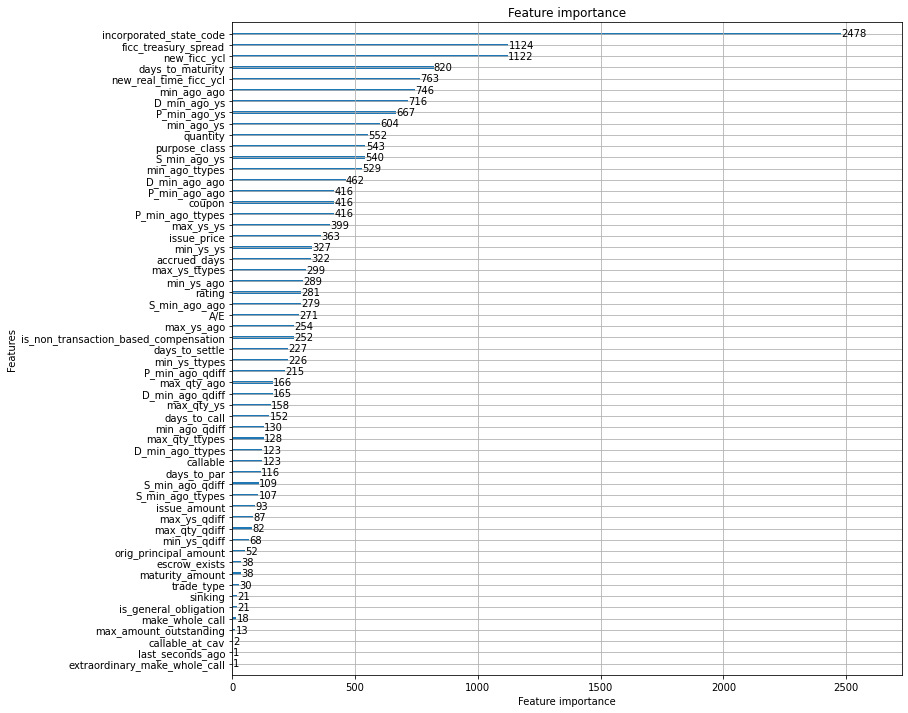

In [250]:
lightgbm.plot_importance(model_baseline.estimators_[0], figsize = (12,12))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

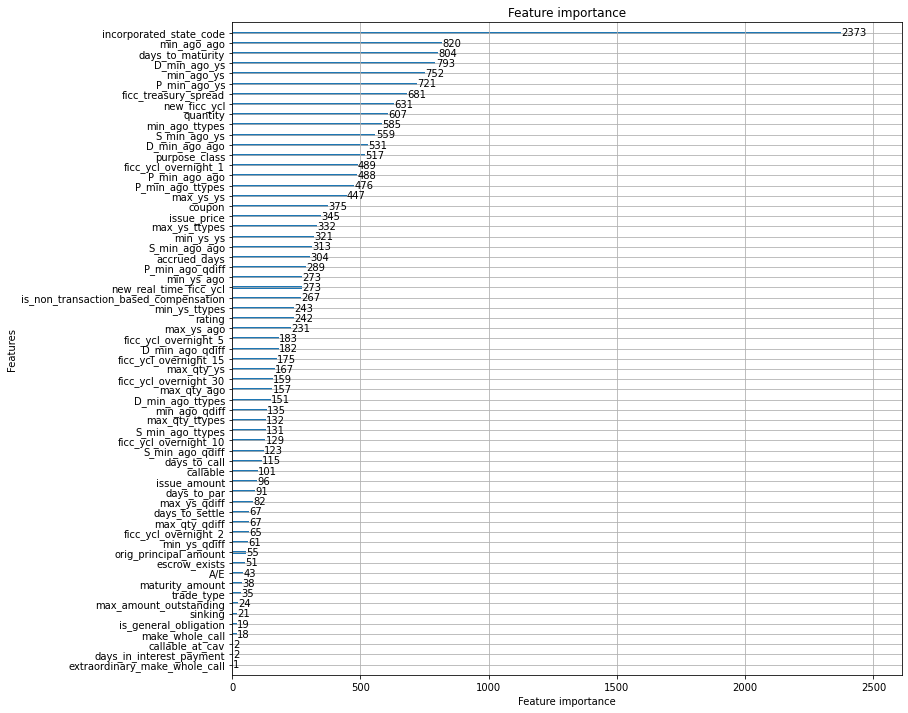

In [249]:
lightgbm.plot_importance(model_overnight.estimators_[0], figsize = (12,12))